<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/gru-implementation/gru-architecture/GRU_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 186 kB 53.9 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 
     |████████████████████████████████| 51 kB 283 kB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *

Implement Gated Recurrent Unit

In [9]:
from IPython.display import SVG
def show_svg():
    display(SVG(url='https://upload.wikimedia.org/wikipedia/commons/3/37/Gated_Recurrent_Unit%2C_base_type.svg'))

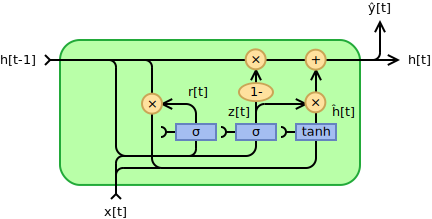

In [10]:
show_svg()

In [24]:
class GRUImpl(Module):
  def __init__(self, ni, nh):
    self.reset_gate = nn.Linear(ni+nh, nh)
    self.update_gate = nn.Linear(ni+nh, nh)

  def forward(self, input, state):
    h,_ = state
    h_1 = torch.cat([h, input], dim = 1)
    reset = torch.sigmoid(self.reset_gate(h_1))
    update = torch.sigmoid(self.update_gate(h_1))
    h_2 = torch.cat([reset * h, input], dim = 1)
    
    out = torch.tanh(h_2)
    h *= (1 - update)
    h += (activation * update)

    return h

Simplified version to do one big matrix operation

In [25]:
class GRUImpl(Module):
  def __init__(self, ni, nh):
    self.ih = nn.Linear(ni, 2*nh)
    self.hh = nn.Linear(nh, 2*nh)
  def forward(self, input, state):
    h = state
    gates = (self.ih(input) + self.hh(h)).chunk(2,1)
    resetgate, updategate = map(torch.sigmoid, gates[:2])

    out = torch.tanh(torch.cat([resetgate * h, input], dim = 1))
    h *= (1 - updategate)
    h += (out * updategate)

    return h